In [1]:
import numpy as np
import pandas as pd
import torch
import proloaf.datahandler as dh
import proloaf.tensorloader as tl
import proloaf.metrics as metrics
import proloaf.plot as plot
import proloaf.modelhandler as mh

import os
from proloaf.cli import parse_basic
from proloaf.confighandler import read_config
from IPython.display import display
import ipywidgets as widgets

# Using ProLoaF for hourly predictions of the German power consumption of the open power system data platform

## 1) Data Selection, Preprocessing, and Configuration of Forecasting Model

First, we need to make sure that we either use local or external data (preferably in csv or xlsx format). We make ProLoaF aware of the data-path and some details that need to be taken care of during pandas dataframe reading through or preprocessing config. For more infos on the confid checkout the [configuration-helper](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/)

> **NOTE:** If you start with your forecasting task already with all features integrated in one csv file, you can skip the whole preprocessing step.

We now use preprocess.py to do the job of importing, interpolation, aligning the timesteps, taking the minimum joint period of input data, and generating one hot encoding and cyclical encoding of calendric data, that is based on the timestamp.
More infos on the interpolation techniques is explained in [this notebook-section](./Step-by-step%20user%20guide%20on%20train.py.ipynb#1.-Dealing-with-missing-values-in-the-data).

In [2]:
!python3 ../src/preprocess.py -s opsd_24

Importing CSV Data...
Importing time_series/2020-10-06/time_series_60min_singleindex.csv ...
...Importing finished. 
Importing weather_data/2020-09-16/weather_data.csv ...
...Importing finished. 
Some values are NaN. They are being filled...
...interpolation finished! No missing data left.
                     AT_load_actual_entsoe_transparency  DE_load_actual_entsoe_transparency
Time                                                                                       
2014-12-31 23:00:00                              5946.0                             41151.0
2015-01-01 00:00:00                              5946.0                             41151.0
2015-01-01 01:00:00                              5726.0                             40135.0
2015-01-01 02:00:00                              5347.0                             39106.0
2015-01-01 03:00:00                              5249.0                             38765.0
...                                                 ...          

## 2) Training

You can use the shell command that allows interactive options to set hyperparameter tuning on or off and decide upon whether or not to overwrite the configuration files the final parameters. 

```python3 ../src/train.py -s opsd_24```

You can also use currently a workaround with the CI flag to turn off all upcoming queries. Simply add --ci when calling the script. 
Upon sucessful run of train.py, it will generate a trained RNN model that is stored in the path 'oracles'.
A step-by-step guide to what is done in train.py follows in [this notebook](./Step-by-step%20user%20guide%20on%20train.py.ipynb).

### 3) ProLoaF Performance Check
We now want to give a deeper look into the 24h-forecast the RNN is able to generate.

### Read in config file and set active paths 
Assuming opsd_24 exists in 'targets' and the model has been trained already, so it is stored in 'oracles' (see step 2))

In [3]:
config_path = 'opsd_24'
PAR = read_config(config_path, main_path="../")
torch.manual_seed(1)
model_name = PAR["model_name"]
data_path = PAR["data_path"]
INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])
DEVICE = "cpu"

target_id = PAR["target_id"]
SPLIT_RATIO = PAR["validation_split"]
HISTORY_HORIZON = PAR["history_horizon"]
FORECAST_HORIZON = PAR["forecast_horizon"]
feature_groups = PAR["feature_groups"]

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

### Load Data, Interpolate any missing values, and Split to use Test-Set only

In [4]:
# Read load data
df = pd.read_csv(INFILE, sep=";")
df = dh.fill_if_missing(df)
split = int(len(df.index) * SPLIT_RATIO)

No missing data 



In [5]:
#Originally we have trained the model to predict 24h ahead.
adj_forecast_horizon = widgets.IntSlider(value=PAR["forecast_horizon"])
display(adj_forecast_horizon)

IntSlider(value=24)

In [6]:
FORECAST_HORIZON = adj_forecast_horizon.value

### Re-load Trained RNN and Generate Tensor using ProLoaF Dataloader

In [7]:
with torch.no_grad():
    net = torch.load(os.path.join("../",PAR["output_path"], model_name), map_location=torch.device(DEVICE))  # mapping to CPU
    
    df_new, _ = dh.scale_all(df, scalers=net.scalers, **PAR)
    df_new.index = df['Time']
    df_test = df_new.iloc[int(len(df.index) * PAR["validation_split"]):]
    
    _,_,test_data_loader = dh.transform(
        df_new,
        device=DEVICE,
        **PAR,)

Size training set: 	26295
Size validation set: 	8765


In [8]:
print("Number of Test Samples (1st dimension): ", test_data_loader.dataset.inputs2.shape[0])
print("Forecast Horizon (2nd dimension): ", test_data_loader.dataset.inputs2.shape[1])
print("Number of Features (3rd dimension): ", test_data_loader.dataset.inputs2.shape[2])

Number of Test Samples (1st dimension):  8595
Forecast Horizon (2nd dimension):  24
Number of Features (3rd dimension):  43


Imagine the 3D-tensor to have these dimensions as mentioned above
![Grafik](./figures/3d-tensor.jpg)

### Fetch Predictions

In [9]:
# fetch forecast horizon from the shape of the targets (check)
horizon = test_data_loader.dataset.targets.shape[1]
number_of_targets = test_data_loader.dataset.targets.shape[2]

record_targets, record_output = mh.get_prediction(net, test_data_loader, 
                                                  horizon, number_of_targets)

net.eval()

EncoderDecoder(
  (encoder): Encoder(
    (core): LSTM(5, 48, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (core): LSTM(43, 48, batch_first=True, dropout=0.3)
    (fc1): Linear(in_features=48, out_features=48, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc2): ModuleList(
      (0): Linear(in_features=48, out_features=1, bias=True)
      (1): Linear(in_features=48, out_features=1, bias=True)
    )
  )
)

### Fetch prediction upper bounds, lower bounds and mean expected values
This process is score dependent. We refer to the score with the term "criterion". Per default, ProLoaF trains with GNLL (=Negative Log-Likelihood under the assumption of a Standard-Normal Distribution)

In [10]:
criterion = net.criterion

In [11]:
y_pred_upper, y_pred_lower, record_expected_values = mh.get_pred_interval(
    record_output, criterion, record_targets)

### Let's Calculate the Deterministic and Probabilistic Forecast Metrics on the Test Set

In [12]:
analyzed_metrics=[
    "mse",
    "rmse",
    "sharpness",
    "picp",
    "rae",
    "mae",
    "mis",
    "mase",
    "pinball_loss",
    "residuals"
]

### Choose time steps of interest and plot those

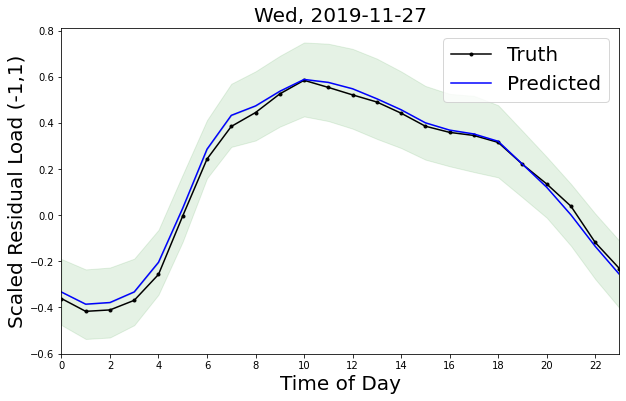

One can also plot a desired limit, to visually indicate congestion in high load situations.


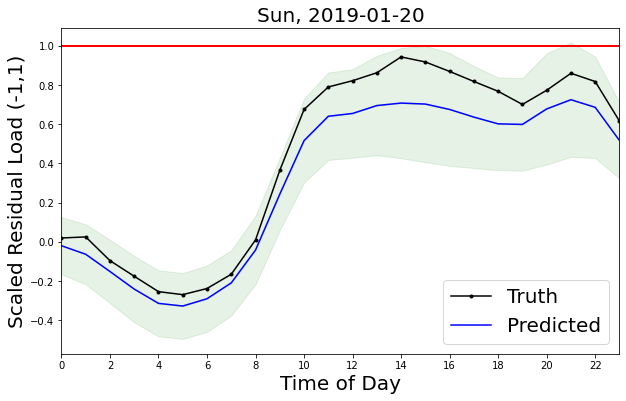

In [13]:
testhours = [-840]
#h=-840 is a Wednesday

# Fetch the actual time from the datetimeindex in the pandas dataframe
actual_time = pd.to_datetime(df.loc[HISTORY_HORIZON+split:, "Time"])
for i in testhours:
    hours = actual_time.iloc[i : i + FORECAST_HORIZON]
    plot.plot_timestep(
        record_targets[i].detach().numpy(),
        record_expected_values[i].detach().numpy(),
        y_pred_upper[i].detach().numpy(),
        y_pred_lower[i].detach().numpy(),
        i,
        OUTDIR,
        limit=None,
        actual_time=hours,
    )

# Plot for days with possible congestion
print("One can also plot a desired limit, to visually indicate congestion in high load situations.")

testhours = [314]
#h=314 is a Sunday
actual_time = pd.to_datetime(df.loc[HISTORY_HORIZON+split:, "Time"])
for i in testhours:
    hours = actual_time.iloc[i : i + FORECAST_HORIZON]
    plot.plot_timestep(
        record_targets[i].detach().numpy(),
        record_expected_values[i].detach().numpy(),
        y_pred_upper[i].detach().numpy(),
        y_pred_lower[i].detach().numpy(),
        i,
        OUTDIR,
        limit=1,
        actual_time=hours,
        draw_limit = True,
    )

### How does the forecast model perform on average?

In [14]:
results = metrics.fetch_metrics(
    targets=record_targets,
    expected_values=record_expected_values,
    y_pred_upper=y_pred_upper,
    y_pred_lower=y_pred_lower,
    analyzed_metrics=analyzed_metrics #all above listes metrics are fetched
)

In [15]:
print(metrics.results_table(model_name,results,save_to_disc=OUTDIR))

                        mse      rmse  sharpness       picp       mis  \
opsd_24_LSTM_gnll  0.007613  0.087251   0.399651  98.649902  0.473824   

                       mase       rae       mae  
opsd_24_LSTM_gnll  0.113817  0.150793  0.056311  


### Does the prediction perform equally good or bad over the whole test set?
We have fetched the predictions over the chosen forecast horizon for every hour in the test set. Let us visualize how this is done.

![Grafik](./figures/tensor-structure.jpg)
Since every sample is shifted by a time-delta, or let's day a sample-frequency (here: frequency=1), we achieve as many samples as is possible by the given data set.

A boxplot will serve as the most practical plot to show how much the error metrics deviate
from one forecast situation to another. We refer to each forecast situation as one sample.


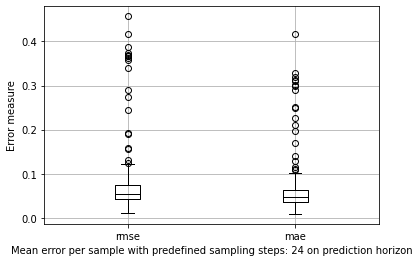

Remember that the number of test samples is 8595 .
The period ranges from Sun, 2019-01-06 to Tue, 2019-12-31 .
For sake of clarity we have plotted the samples in 24h intervals resulting in: 358.125 days in the test set.


In [16]:
print("A boxplot will serve as the most practical plot to show how much the error metrics deviate\nfrom one forecast situation to another. We refer to each forecast situation as one sample.")
# BOXPLOTS
with torch.no_grad():
    plot.plot_boxplot(
        targets=record_targets,
        expected_values=record_expected_values,
        y_pred_upper=y_pred_upper,
        y_pred_lower=y_pred_lower,
        analyzed_metrics=['rmse', 'mae'],
        sample_frequency=24,
        save_to_disc=OUTDIR,
    )
print("Remember that the number of test samples is", test_data_loader.dataset.inputs2.shape[0], ".")
print("The period ranges from",actual_time.iloc[0].strftime("%a, %Y-%m-%d"), "to", actual_time.iloc[-1].strftime("%a, %Y-%m-%d"), ".")
print("For sake of clarity we have plotted the samples in 24h intervals resulting in:", test_data_loader.dataset.inputs2.shape[0]/24, "days in the test set.")

### How does the forecast perform on average over the forecast period (=24 hours)?

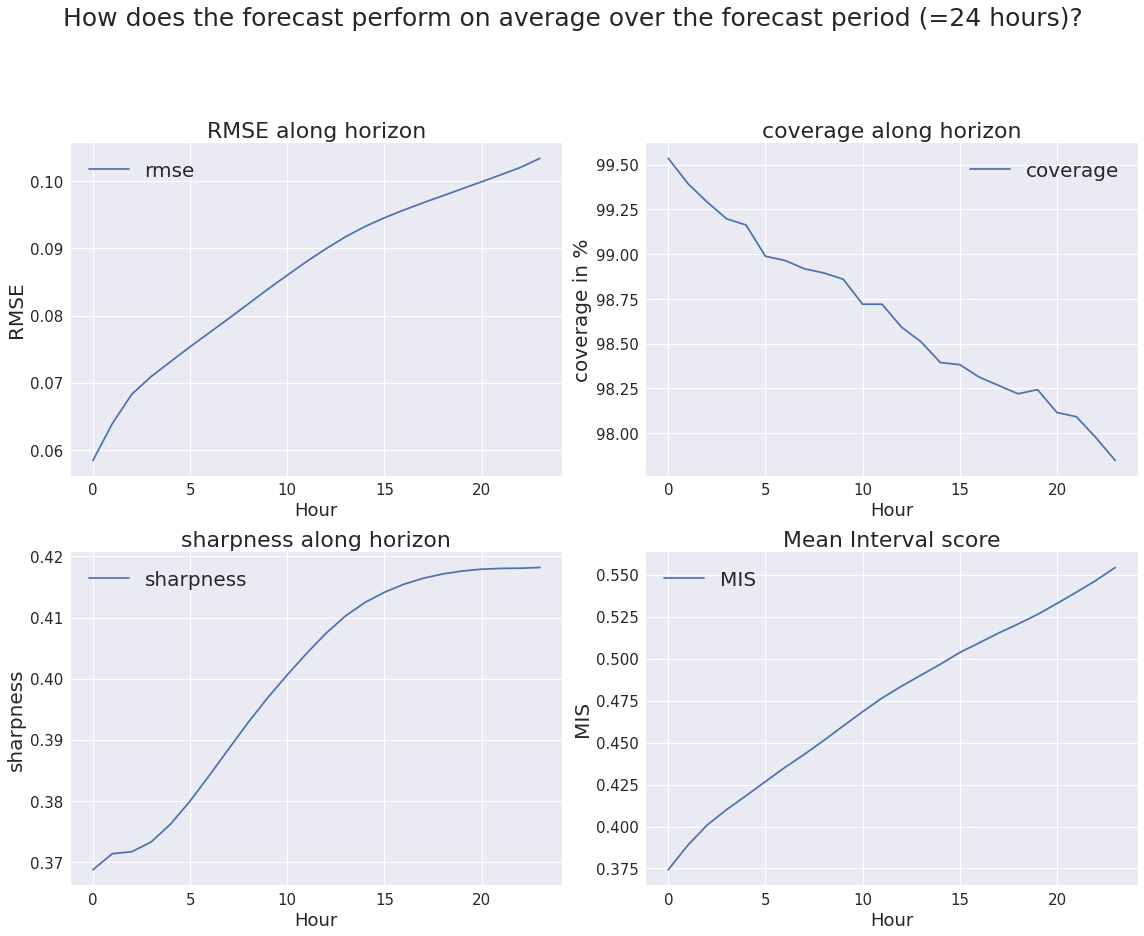

In [17]:
#first fetch the metrics per time step on the forecast horizon (=24 hours in our case)
results_per_timestep = metrics.fetch_metrics(
    targets=record_targets,
    expected_values=record_expected_values,
    y_pred_upper=y_pred_upper,
    y_pred_lower=y_pred_lower,
    analyzed_metrics=["rmse",
                      "sharpness",
                      "picp",
                      "mis"],
    total=False,
)

# plot metrics
plot.plot_metrics(
    results_per_timestep["rmse"],
    results_per_timestep["sharpness"],
    results_per_timestep["picp"],
    results_per_timestep["mis"],
    OUTDIR,
    title="How does the forecast perform on average over the forecast period (=24 hours)?"
)